# 商事主体 - 预警 - ARIMA
---


In [12]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
% matplotlib inline

# 设置plt中文支持
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

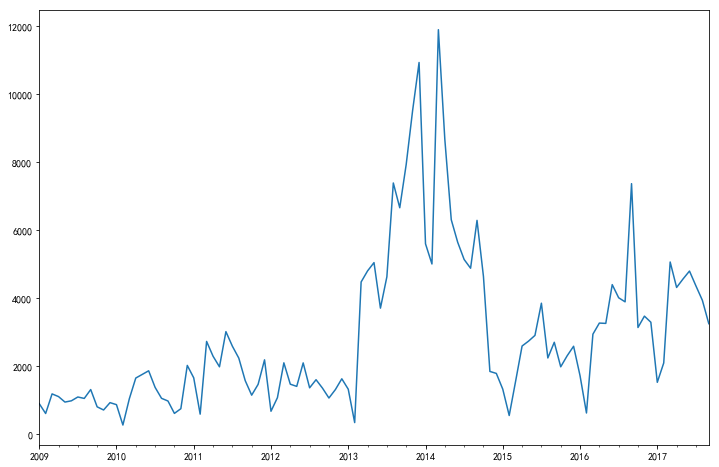

In [29]:
m_index = pd.date_range('2009-01', '2018-01', freq='M')

# 读入数据
m_datas = pd.read_excel('月-商事主体新注册总量.xlsx')

# 按年过滤数据
year = ['2017', '2016', '2015', '2014', '2013', '2012', '2011', '2010', '2009']
sel = [i for i in m_datas['年月日'] if i[0:4] in year]  # 选择指定年份数据
m_datas = m_datas[m_datas['年月日'].isin(sel)]

# 年月日索引
m_datas['年月日'] = m_datas['年月日'].apply(lambda x: x.strip('日').replace('年', '-').replace('月', '-'))
m_datas['年月日'] = pd.to_datetime(m_datas['年月日'])
m_datas.sort_values(by=['年月日'], inplace=True)
m_datas.index = m_index[0:-2]
m_datas = m_datas[:-1]  # 删除17年10月的数据

# 个体工商户 每月新注册数量  数据预处理
ib_sel = m_datas['个体工商户']

fig = plt.figure(figsize=[12, 8])
ax = fig.add_subplot(111)
ib_sel.plot(ax=ax)

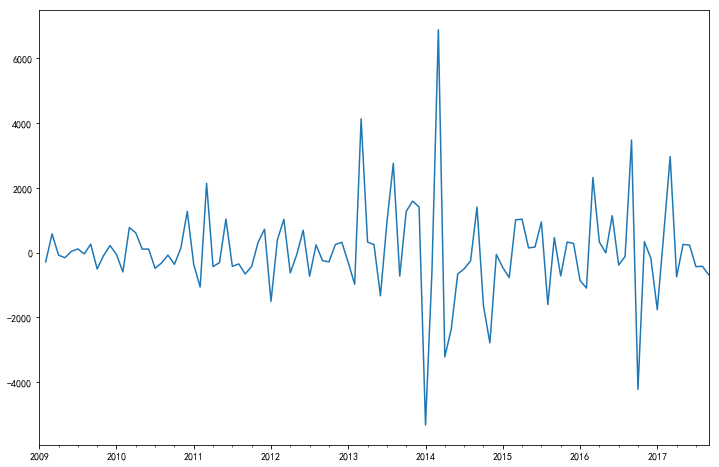

In [14]:
# 一阶差分 -- 序列平稳化
fig = plt.figure(figsize=[12,8])
ax = fig.add_subplot(111)
diff1 = ib_sel.diff(1)
diff1.plot(ax=ax)

## 确定 ARIMA 参数
---
d = 1

p = 4

q = 1

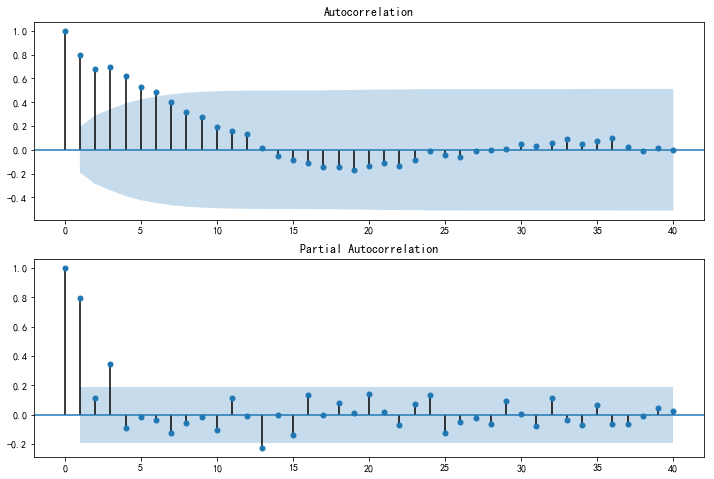

In [15]:
# ACF & PACF 图
fig = plt.figure(figsize=[12,8])
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ib_sel, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ib_sel, lags=40, ax=ax2)

In [16]:
model_01 = sm.tsa.ARIMA(ib_sel, (2, 1, 0)).fit()
print('模型 1', model_01.aic, model_01.bic, model_01.hqic)

model_02 = sm.tsa.ARIMA(ib_sel, (3, 1, 0)).fit()
print('模型 2', model_02.aic, model_02.bic, model_02.hqic)

model_03 = sm.tsa.ARIMA(ib_sel, (2, 1, 1)).fit()
print('模型 3', model_03.aic, model_03.bic, model_03.hqic)

model_04 = sm.tsa.ARIMA(ib_sel, (3, 1, 1)).fit()
print('模型 4', model_04.aic, model_04.bic, model_04.hqic)

模型 1 1794.7744563743165 1805.35201997 1799.05973824
模型 2 1796.5692603570787 1809.79121485 1801.92586269
模型 3 1796.5414452625157 1809.76339976 1801.89804759
模型 4 1798.5294594340533 1814.39580483 1804.95738223


### 德宾-沃森（Durbin-Watson）检验
---
德宾-沃森检验,简称D-W检验，是目前检验自相关性最常用的方法，但它只使用于检验一阶自相关性。因为自相关系数ρ的值介于-1和1之间，所以 0≤DW≤４。
* DW＝O <＝＞ρ＝１　   即存在正自相关性
* DW＝４＜＝＞ρ＝－１　即存在负自相关性
* DW＝２＜＝＞ρ＝０　　即不存在（一阶）自相关性

因此，当DW值显著的接近于O或４时，则存在自相关性，而接近于２时，则不存在（一阶）自相关性。这样只要知道ＤＷ统计量的概率分布，在给定的显著水平下，根据临界值的位置就可以对原假设Ｈ０进行检验。

1.96413121827


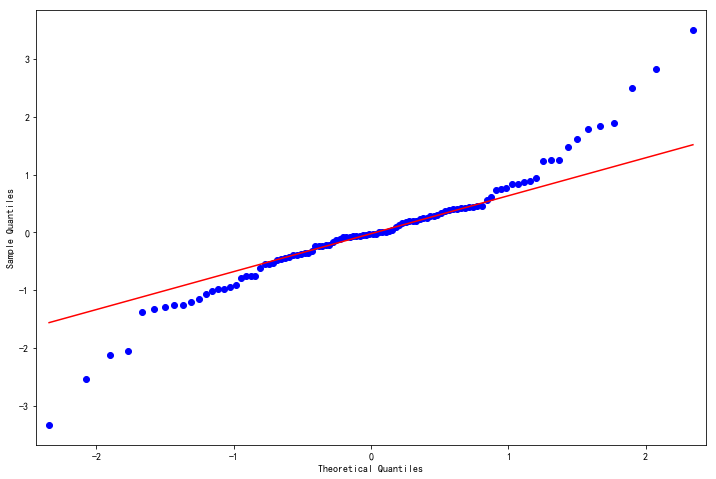

In [17]:
model = model_01

# 德宾-沃森（Durbin-Watson）检验
dw = sm.stats.durbin_watson(model.resid.values)
print(dw)

resid = model.resid #残差
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q', ax=ax, fit=True)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


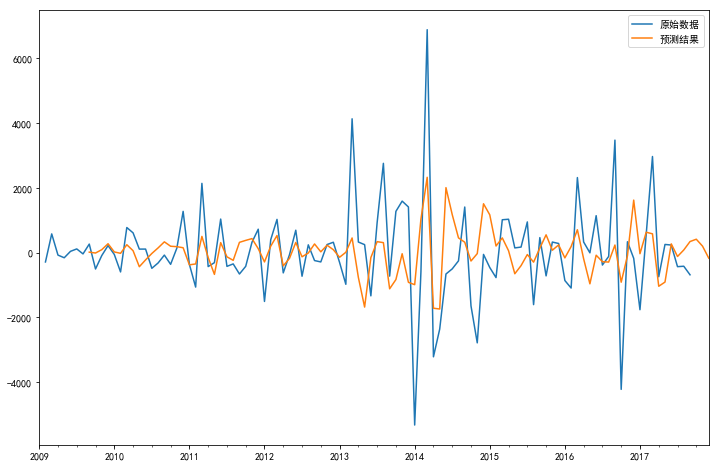

In [18]:
pred = model.predict(start=m_index[-100], end=m_index[-1])

fig, ax = plt.subplots(figsize=(12,8))
ax = ib_sel.ix['2009-01-31':].diff(1).plot(ax=ax, legend='原始数据')
pred.plot(ax=ax, legend='预测结果')
ax.legend(['原始数据', '预测结果'])


In [23]:
# 一阶差分还原
ib_pre = pd.DataFrame(ib_sel[m_index[-100:-1]])
ib_pre['一阶差分'] = ib_sel[m_index[-101:-1]].diff(1)
ib_pre['预测差分'] = pred
ib_pre[-4:]

,个体工商户,一阶差分,预测差分
2017-08-31,3941.0,-423.0,79.247452
2017-09-30,3253.0,-688.0,339.763651
2017-10-31,NaN,NaN,411.540371
2017-11-30,NaN,NaN,197.228321


In [20]:
3253 + 411

3664

In [ ]:
3253 + 411 + 197